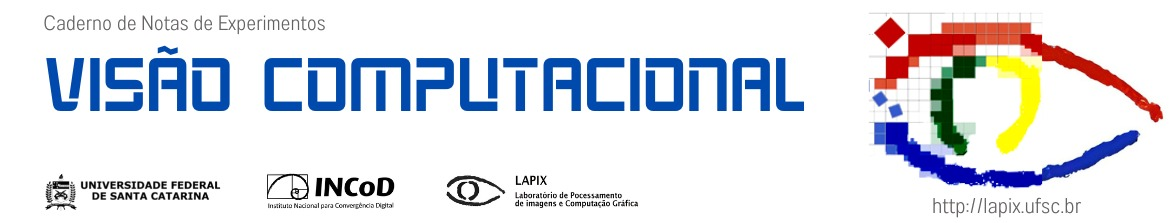






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/06.3.Segmenta%C3%A7%C3%A3o%20por%20Crescimento%20de%20Regi%C3%B5es%20-%20Algoritmos%20Avan%C3%A7ados.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-green" alt="Python Version" title="Python Version"></a>

# 06.2.Segmentação por Crescimento de Regiões - Algoritmos Avançados

A busca pelo sonho de consumo do algoritmo genérico para dividir uma imagem nos objetos ali representados levou ao desenvolvimento de algoritmos de segmentação bastante elaborados, que tentavam unir várias técnicas diferentes e várias representações diferentes do conteúdo de uma imagem: grafos dos objetos na imagem, representação de longos gradientes suaves por grandes regiões da imagem representando o mesmo objeto que variava de luminosidade, similaridade de pixel baseada em características específicas de imagens de satélite ou outras e por aí vai. Alguns players de peso como a NASA tentaram a sua sorte neste tipo de algoritmo.

A maioria desses algoritmos foram implementados em linguagens de programação compiladas e existiram apenas na forma de executáveis que podiam ser baixados ou de código fonte em linguagem C ou C++. Como a pesquisa nesses algoritmos é anterior ao grande sucesso da linguagem Python, que estamos vendo agora, e as pesquisas agora estão voltadas para o desenvolvimento de algoritmos baseados em aprendizado profundo, muito poucos dos algoritmos que discutimos na nossa aula de segmentação avançada acabaram recebendo uma implementação em Python. O algoritmo de segmentação baseado em gráficos de Felzenszwalb & Huttenlocher, que possui um nome tão prosaico que ele só é citado pelas suas iniciais FH, é um dos poucos exemplos que nós podemos executar em Python. Abaixo vão alguns exemplos de sua execução.



### Configurações GPU e PATH

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    ![ -d vision ] || git clone https://github.com/awangenh/vision
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())

os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Running on Google Colab =  True
Cloning into 'vision'...
remote: Enumerating objects: 6718, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 6718 (delta 9), reused 8 (delta 5), pack-reused 6691 (from 4)
Receiving objects: 100% (6718/6718), 671.28 MiB | 22.08 MiB/s, done.
Resolving deltas: 100% (471/471), done.
Updating files: 100% (3931/3931), done.


In [2]:
if  _ON_COLAB:
    # If you are Running on Google Colab,
    # Move vision/data one level up, into the root folder
    !mv vision/data ..
!ls -al ..

total 460
drwxr-xr-x   1 root root   4096 Apr 22 16:24 .
drwxr-xr-x   1 root root   4096 Apr 22 16:24 ..
lrwxrwxrwx   1 root root      7 Jun 27  2024 bin -> usr/bin
drwxr-xr-x   2 root root   4096 Apr 18  2022 boot
drwxr-xr-x   1 root root   4096 Apr 22 16:23 content
-rw-r--r--   1 root root   4332 Jul 10  2024 cuda-keyring_1.1-1_all.deb
drwxr-xr-x   9 root root   4096 Apr 22 16:23 data
drwxr-xr-x   1 root root   4096 Apr 17 13:48 datalab
drwxr-xr-x   5 root root    360 Apr 22 16:21 dev
-rwxr-xr-x   1 root root      0 Apr 22 16:21 .dockerenv
drwxr-xr-x   1 root root   4096 Apr 22 16:21 etc
drwxr-xr-x   2 root root   4096 Apr 18  2022 home
drwxr-xr-x   3 root root   4096 Apr 22 16:21 kaggle
lrwxrwxrwx   1 root root      7 Jun 27  2024 lib -> usr/lib
lrwxrwxrwx   1 root root      9 Jun 27  2024 lib32 -> usr/lib32
lrwxrwxrwx   1 root root      9 Jun 27  2024 lib64 -> usr/lib64
lrwxrwxrwx   1 root root     10 Jun 27  2024 libx32 -> usr/libx32
drwxr-xr-x   2 root root   4096 Jun 27  2024 me

#### Mount your Google Drive as a Folder

If you're using Google Colab together with your Google Drive, adapt this code below to point to the place where you've copied our Git in your Google Drive:

In [ ]:
# Code to mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Look at the contents of your Drive:

In [ ]:
!ln -s "/content/drive/My Drive"

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

image = cv2.imread("../data/ct-02.jpg", cv2.IMREAD_GRAYSCALE)
#image = img_as_float(img[::2, ::2])


# def my_fh(scale=195, sigma=5.29, min_size=12500, colormap='magma'):
def my_fh(preset='Default', scale=100, sigma=1.0, min_size=1000, colormap='magma'):
    global image

    if preset != 'Custom':
        params = param_sets[preset]
        scale = params['scale']
        sigma = params['sigma']
        min_size = params['min_size']

    colormap = eval('plt.cm.' + colormap)
    segments_fh = felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size)

    fig, ax = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(image, segments_fh))
    ax[0].set_title('Original with Boundaries: F&H')

    ax[1].imshow(segments_fh, cmap=colormap, interpolation='nearest')
    ax[1].set_title('Segments: Felzenszwalb & Huttenlocher')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()


param_sets = {
    'Custom': {},
    'Default': {'scale': 285, 'sigma': 1.87, 'min_size': 11790}
}


interact_manual(
    my_fh,
    preset=param_sets.keys(),
    scale=(0, 1000, 5),
    sigma=(0.01, 10, 0.01),
    min_size=(50, 20000, 10),
    colormap=['nipy_spectral', 'hot', 'magma', 'seismic']
)

interactive(children=(Dropdown(description='preset', index=1, options=('Custom', 'Default'), value='Default'),…

<function __main__.my_fh(preset='Default', scale=100, sigma=1.0, min_size=1000, colormap='magma')>

### SciKit F&H with Color Images

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ipywidgets import interact, interactive, interact_manual
from skimage.data import astronaut
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = cv2.imread("../data/car-01.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = img_as_float(img)


def my_fh(preset='Custom', scale=10, sigma=4.2, min_size=1000):
    global image

    if preset != 'Custom':
        params = param_sets[preset]
        scale = params['scale']
        sigma = params['sigma']
        min_size = params['min_size']

    segments_fh = felzenszwalb(image, scale=scale, sigma=sigma, min_size=min_size, channel_axis=-1)

    fig, ax = plt.subplots(ncols=2, figsize=(19, 7), sharex=True, sharey=True)

    ax[0].imshow(mark_boundaries(image, segments_fh))
    ax[0].set_title('Original with Boundaries: F&H')

    ax[1].imshow(segments_fh, cmap=plt.cm.nipy_spectral, interpolation='nearest')
    ax[1].set_title('Segments: Felzenszwalb & Huttenlocher')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


param_sets = {
    'Custom': {},
    'Default': {'scale': 1, 'sigma': 0.8, 'min_size': 20},
    'Preset': {'scale': 142, 'sigma': 4.2, 'min_size': 1100}
}


interactive(
    my_fh,
    preset=param_sets.keys(),
    scale=(0, 200, 2),
    sigma=(0, 10, 0.2),
    min_size=(0, 15000, 100),
)

interactive(children=(Dropdown(description='preset', options=('Custom', 'Default', 'Preset'), value='Custom'),…

### PEGBIS F&H Implementation

Here we will use the **PEGBIS** *(Python Efficient Graph-Based Image Segmentation)*, a Python implementation by Ghassem Alaee of the "Efficient Graph-Based Image Segmentation" paper written by P. Felzenszwalb, D. Huttenlocher. The paper is available: http://cs.brown.edu/~pff/papers/seg-ijcv.pdf. The C++ implementation is written by the author and is available on: http://cs.brown.edu/~pff/segment/.  You'll find the original author's implementation in https://github.com/salaee/pegbis. The version we are using here had a few adaptations and Python-updates by me.

In [20]:
# Do this once (or each time you restart the kernel if you're using Colab)
# Code below downloads the version stored in my mirror
# wget parameters:
# --backups=1 : renames original file with .1 suffix and writes new file to the intended filename
# -q : run quiet unless there's an error
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/segment_graph.py
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/filter.py
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/fh_segment.py
!wget --backups=1 -q https://raw.githubusercontent.com/awangenh/pegbis/master/disjoint_set.py

In [73]:
# --------------------------------------------------------------------------------
# Segment an image:
# Returns a color image representing the segmentation.
#
# Inputs:
#           in_image: image to segment.
#           sigma: to smooth the image.
#           k: constant for threshold function.
#           min_size: minimum component size (enforced by post-processing stage).
#
# Returns:
#           num_ccs: number of connected components in the segmentation.
# --------------------------------------------------------------------------------
from scipy import ndimage
import matplotlib.pyplot as plt
from filter import *
from segment_graph import *
from fh_segment import *
import time
from ipywidgets import interact, interactive, interact_manual

sigma = 0.5
scale = 100
min_size = 50
input_path = "../data/car-01.jpg"

# Loading the image
#input_image = ndimage.imread(input_path, flatten=False, mode=None)
input_image = plt.imread(input_path)

def my_pegbis(scale=100, sigma=0.5, min_size=50):
    global input_image

    print("processing...")
    output_image, elapsed_time = fh_segment(input_image, sigma, scale, min_size)
    print("Execution time: " + str(int(elapsed_time / 60)) + " minute(s) and " + str(int(elapsed_time % 60)) + " seconds")
    # displaying the result
    fig, ax = plt.subplots(ncols=2, figsize=(14, 7), sharex=True, sharey=True)

    ax[0].imshow(input_image)
    ax[0].set_title('Original')

    ax[1].imshow(output_image)
    ax[1].set_title('Segments: Felzenszwalb & Huttenlocher')

    for a in ax:
        a.set_axis_off()


    plt.tight_layout()
    plt.show()

interact_manual(
    my_pegbis,
    scale=(1, 1000, 100),
    igma=(0.1, 3.0, 0.2),
    min_size=(10, 10000, 10)
    )

interactive(children=(IntSlider(value=100, description='scale', max=1000, min=1, step=100), FloatSlider(value=…

<function __main__.my_pegbis(scale=100, sigma=0.5, min_size=50)>

# Credits

* General tricks for displaying images were from here: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
* We also used a few general tips from: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py

![rodape lapix ufsc](https://github.com/awangenh/vision/blob/master/rodape-CC.png?raw=1)